In [2]:
import os
import random

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import sys

In [3]:
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [4]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

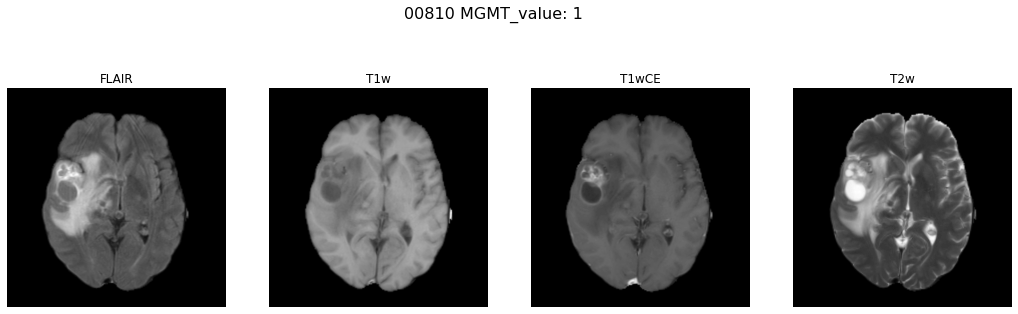

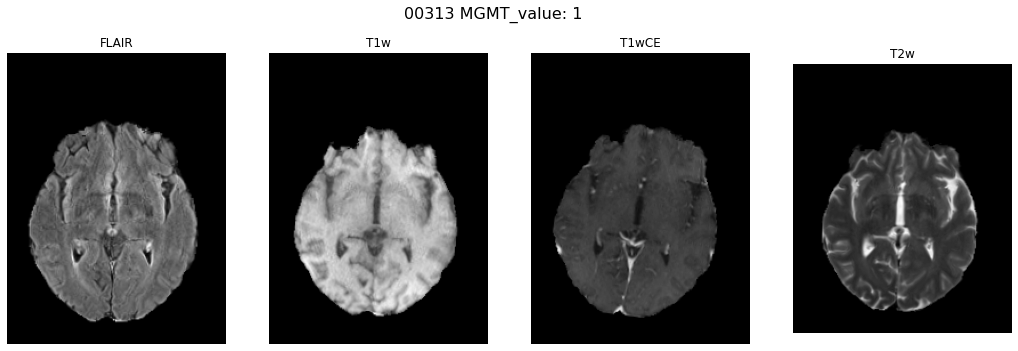

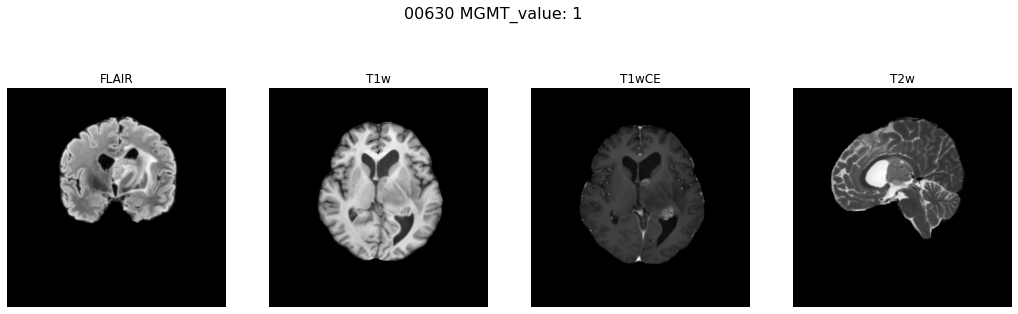

In [5]:
def rand_viz(n):
    train_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train'
    for pat in random.sample(os.listdir(train_path), n):
        MGMT_value = int(train_df.loc[train_df['BraTS21ID'] == 0, 'MGMT_value'])
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 18))
        for type_, ax in zip(("FLAIR", "T1w", "T1wCE", "T2w"), (ax1, ax2, ax3, ax4)):
            path = os.path.join(train_path, pat, type_,)
            imgs = os.listdir(path)
            imgs = sorted(imgs, key=lambda x: int(x[:-4].split('-')[-1]))
            path = os.path.join(path, imgs[int(len(imgs)/2)])
            ax.imshow(load_dicom(path), cmap="gray")
            f.suptitle(f'{pat} MGMT_value: {MGMT_value}', y=0.65, size=16)
            ax.set_title(type_)
            ax.axis("off")
rand_viz(3)           

In [6]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

def show_animation(n, type_, train=True):
    n = str(n).zfill(5)
    if train:
        path = os.path.join('../input/rsna-miccai-brain-tumor-radiogenomic-classification', 'train', n, type_)
    else:
        path = os.path.join('../input/rsna-miccai-brain-tumor-radiogenomic-classification', 'test', n, type_)
    img_names = sorted(os.listdir(path), key=lambda x: int(x[:-4].split('-')[-1]))
    imgs = []
    for name in img_names:
        img = load_dicom(os.path.join(path, name))
        if img.max() != 0:
            imgs.append(img)        
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(imgs[0], cmap="gray")
    
    def animate_func(i):
        im.set_array(imgs[i])
        return [im]
    plt.close(fig)
    return animation.FuncAnimation(fig, animate_func, frames = len(imgs), interval = 1000//24, blit=True)

show_animation(0, 'T1w')

# Model

In [7]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [8]:
NUM_IMAGES = 64
SIZE = 256

In [9]:
def load_dicom_3d(n, type_, num_imgs=NUM_IMAGES, img_size=SIZE, train=True):
    n = str(n).zfill(5)
    if train:
        path = os.path.join('../input/rsna-miccai-brain-tumor-radiogenomic-classification', 'train', n, type_)
    else:
        path = os.path.join('../input/rsna-miccai-brain-tumor-radiogenomic-classification', 'test', n, type_)
    img_names = sorted(os.listdir(path), key=lambda x: int(x[:-4].split('-')[-1]))
    # отбираем {NUM_IMAGES} изображений из середины
    start = max(0, len(img_names)//2-num_imgs//2)
    end = min(len(img_names), len(img_names)//2+num_imgs//2)
    img3d = np.stack([cv2.resize(load_dicom(os.path.join(path, img)), (img_size, img_size)) for img in img_names[start:end]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1])) 
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    return np.expand_dims(img3d,0) # shape: (1, 256, 256, 64)

### Train/Test dataset

In [10]:
train_, test_ = train_test_split(train_df, test_size=0.3, stratify=train_df["MGMT_value"])

In [11]:
import sys
sys.path.append('../input/efficientnetpyttorch3d')
from efficientnet_pytorch_3d import EfficientNet3D
model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)

cuda


In [13]:
class TrainDataset(Dataset):
    
    def __init__(self, data, type_):
        self.data = data.reset_index(drop=True)
        self.type_ = type_
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        n = self.data.loc[index, 'BraTS21ID']
        img3d = load_dicom_3d(n, self.type_, num_imgs=NUM_IMAGES, img_size=SIZE)
        return {'img3d': torch.tensor(img3d, dtype=torch.float).to(device), 
                'label': torch.tensor(self.data.loc[index, 'MGMT_value'], dtype=torch.long).to(device)}
    

class ValDataset(Dataset):
    
    def __init__(self, data, type_):
        self.data = data.reset_index(drop=True)
        self.type_ = type_
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        n = self.data.loc[index, 'BraTS21ID']
        img3d = load_dicom_3d(n, self.type_, num_imgs=NUM_IMAGES, img_size=SIZE)
        return torch.tensor(img3d, dtype=torch.float).to(device)
        
train_dataset = TrainDataset(train_, 'FLAIR')
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = TrainDataset(train_, 'FLAIR')
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_loss = []

                      
for epoch in range(3):
    for n, batch_train in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_train['img3d'])
        loss = criterion(outputs, batch_train['label'])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if n%60 == 0:
            model.eval()
            with torch.no_grad():
                val_loss_ = []
                for batch_val in val_dataloader:
                    outputs = model(batch_val['img3d'])
                    loss = criterion(outputs, batch_val['label'])
                    val_loss_.append(loss.item()) 
                print(f'Iter: {n}, Train_loss: {train_loss[-1]}, Eval_loss: {np.mean(val_loss_)}')
        else:
            print(f'Iter: {n}, Train_loss: {train_loss[-1]}')
        val_loss.append(np.mean(val_loss_))
    print('[%d] loss: %.3f' % (epoch + 1, loss.item()))

print('Finished Training')

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
torch.save(model, 'trained.pth')

In [25]:
with torch.no_grad():
    for batch in val_dataloader:
        print(model(batch['img3d']))
        print(torch.argmax(model(batch['img3d']), dim=1))
        print(torch.sigmoid(model(batch['img3d'])).cpu().numpy().squeeze())
        break

tensor([[ 0.2685, -0.1180],
        [-0.3006,  0.5088],
        [ 0.2261, -0.1221],
        [ 0.0888, -0.0033]], device='cuda:0')
tensor([0, 1, 0, 0], device='cuda:0')
[[0.5470129  0.52279884]
 [0.50340533 0.5223195 ]
 [0.53524673 0.52527124]
 [0.54097384 0.5004947 ]]


In [ ]:
model_2 = torch.load('trained.pth')